# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [3]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [4]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [5]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5
acc_full = accuracy_score(yf_test, ypred_full)
prec_full = precision_score(yf_test, ypred_full)
rec_full = recall_score(yf_test, ypred_full)

acc_reduced = accuracy_score(yr_test, ypred_reduced)
prec_reduced = precision_score(yr_test, ypred_reduced)
rec_reduced = recall_score(yr_test, ypred_reduced)

print(f"Full: accuracy = {acc_full}, precision = {prec_full}, recall = {rec_full}")
print(f"Reduced: accuracy = {acc_reduced}, precision = {prec_reduced}, recall = {rec_reduced}")


Full: accuracy = 0.7233333333333334, precision = 0.7333333333333333, recall = 0.678082191780822
Reduced: accuracy = 0.7166666666666667, precision = 0.7364341085271318, recall = 0.6506849315068494


## 4) Plot ROC and Precision–Recall Curves

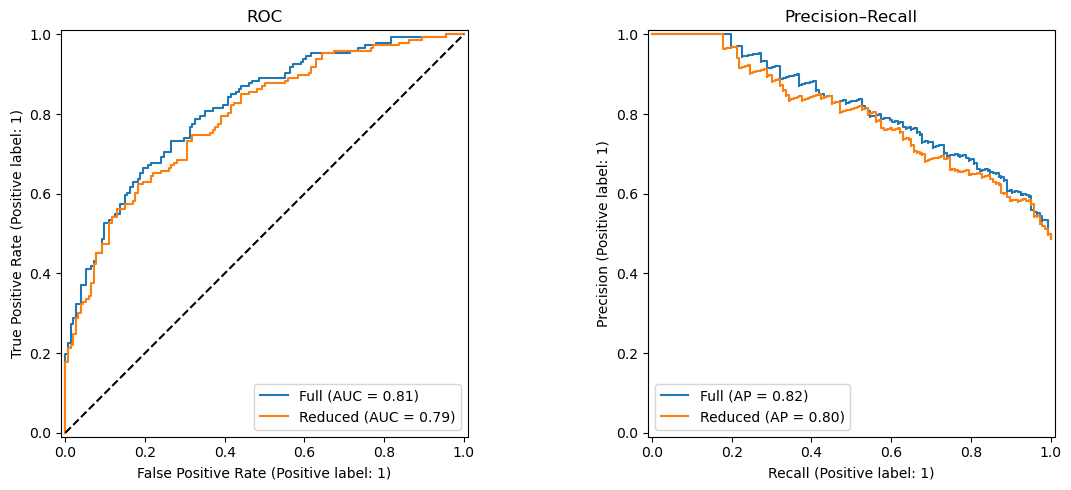

In [8]:
# TODO: Plot ROC and PR curves for both models on shared axes

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(yf_test, yprob_full, name="Full", ax=ax[0])
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, name="Reduced", ax=ax[0])
ax[0].plot([0, 1], [0, 1], "k--")
ax[0].set_title("ROC")

PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, name="Full", ax=ax[1])
PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, name="Reduced", ax=ax[1])
ax[1].set_title("Precision–Recall")

plt.tight_layout()
plt.show()

## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

1. The full model has higher ROC-AUC and higher PR-AP, but only by 2 tenths in both cases. This implies that the addition of PWAT (and VWS) to CAPE does not substaintally increase the ROC-AUC or PR-AP.

2. To maximize event detection, or recall, the full model would be best. To minimize false alarm, or maximize precision, the reduced model would be best. However, neither seems significantly better than another, so in a real-world scenario, the reduced model would likely be best as it would require less data to train.